# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [70]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
ex_stock='XOM'

[*********************100%%**********************]  10 of 10 completed


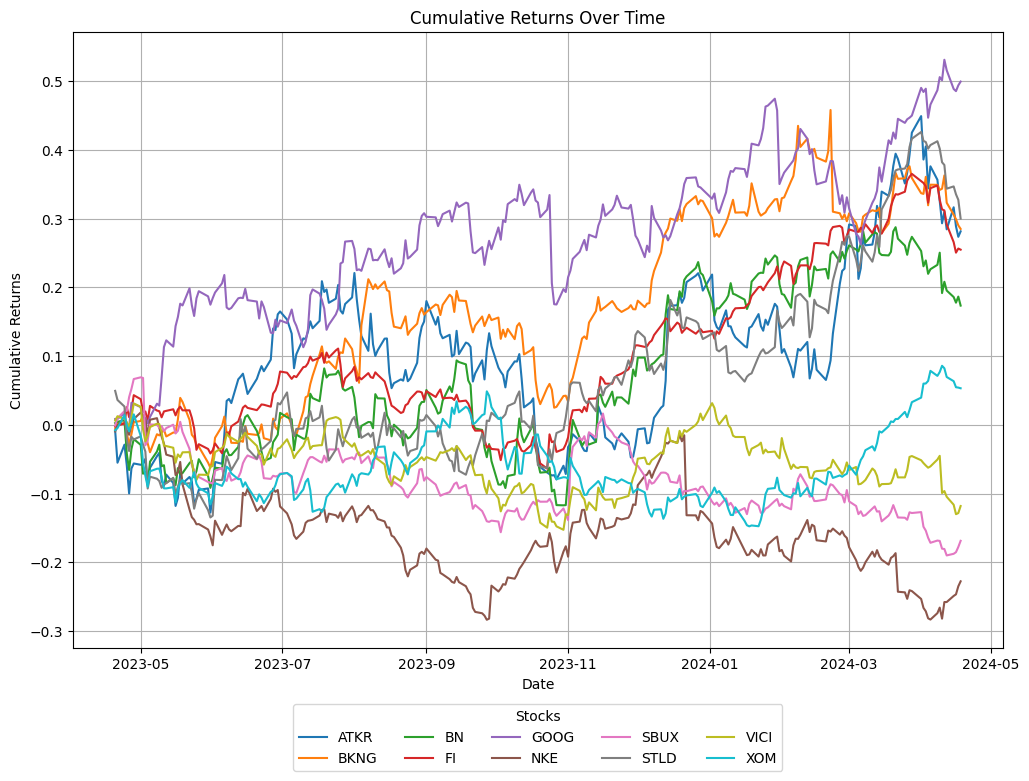

In [71]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [72]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [73]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.23439842542085412
Initial Port Volatility: 0.0802239439947759
Initial Port Sharpe: 2.397020338882571
Optimal Weights: {'ATKR': 0.01, 'BKNG': 0.069, 'BN': 0.01, 'FI': 0.293, 'GOOG': 0.144, 'NKE': -0.111, 'SBUX': -0.143, 'STLD': 0.045, 'VICI': -0.15, 'XOM': 0.024}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

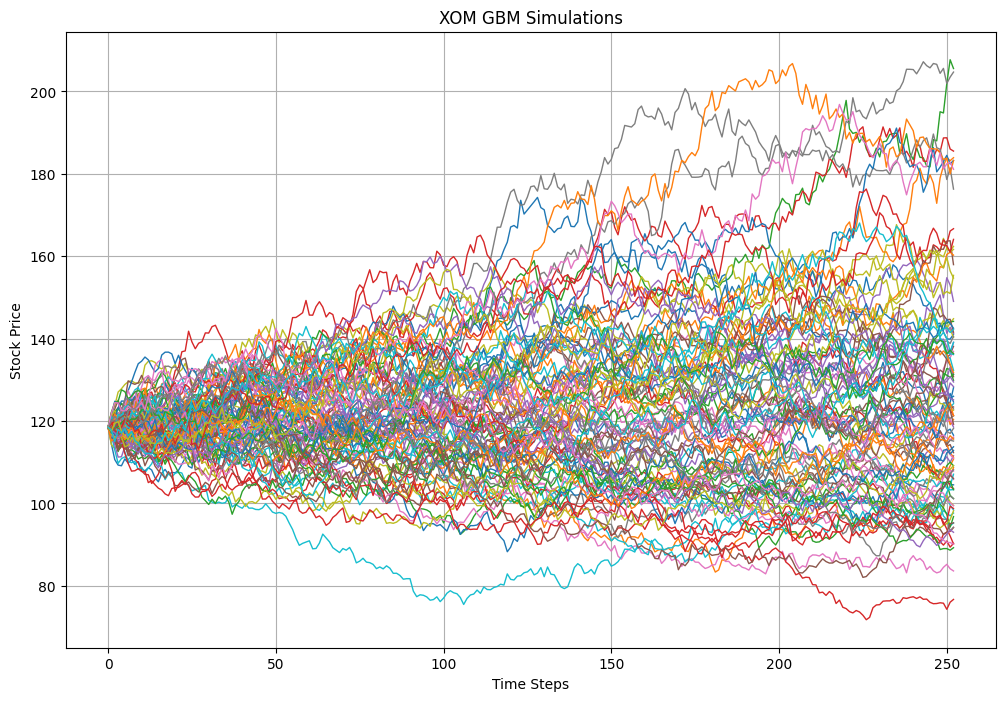

In [74]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

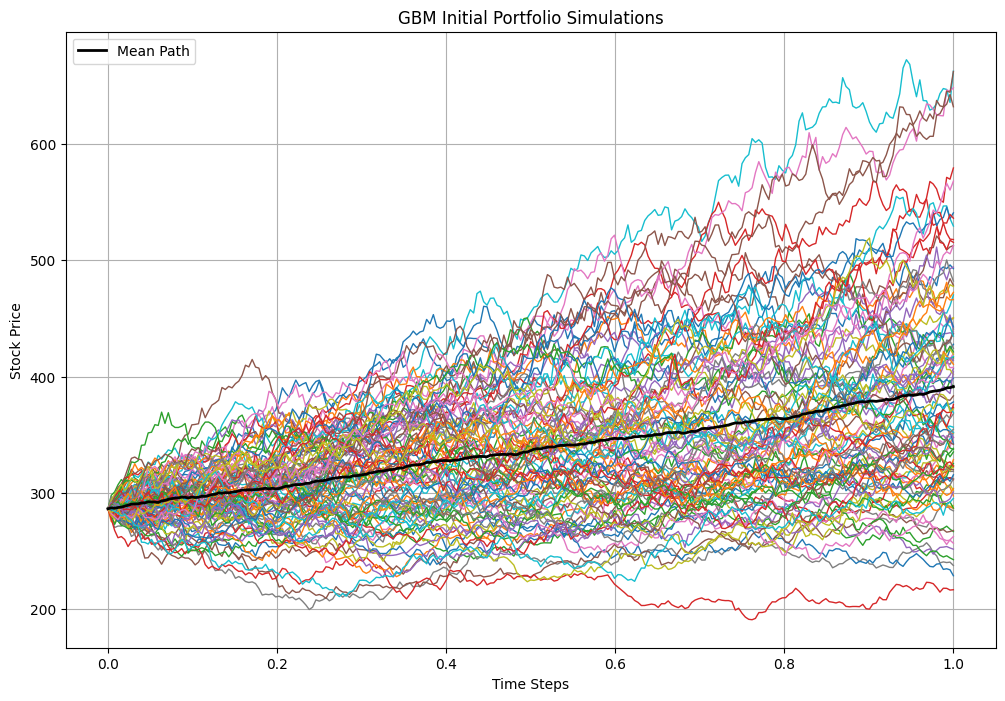

In [75]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [76]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 34.03%


### Merton Jump Diffusion: 

In [77]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

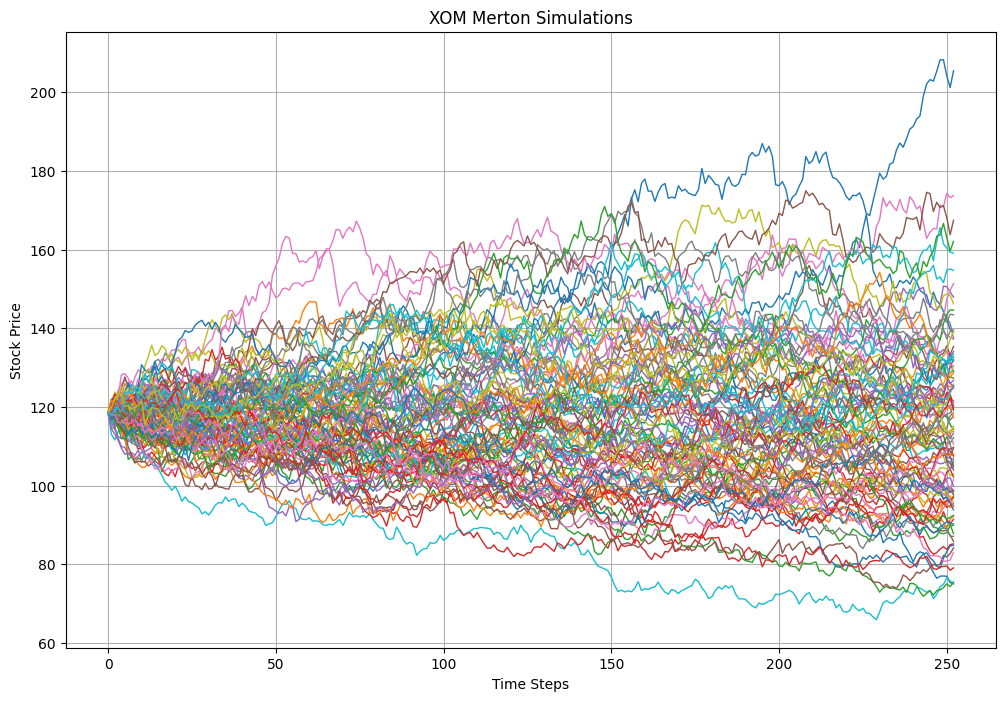

In [78]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

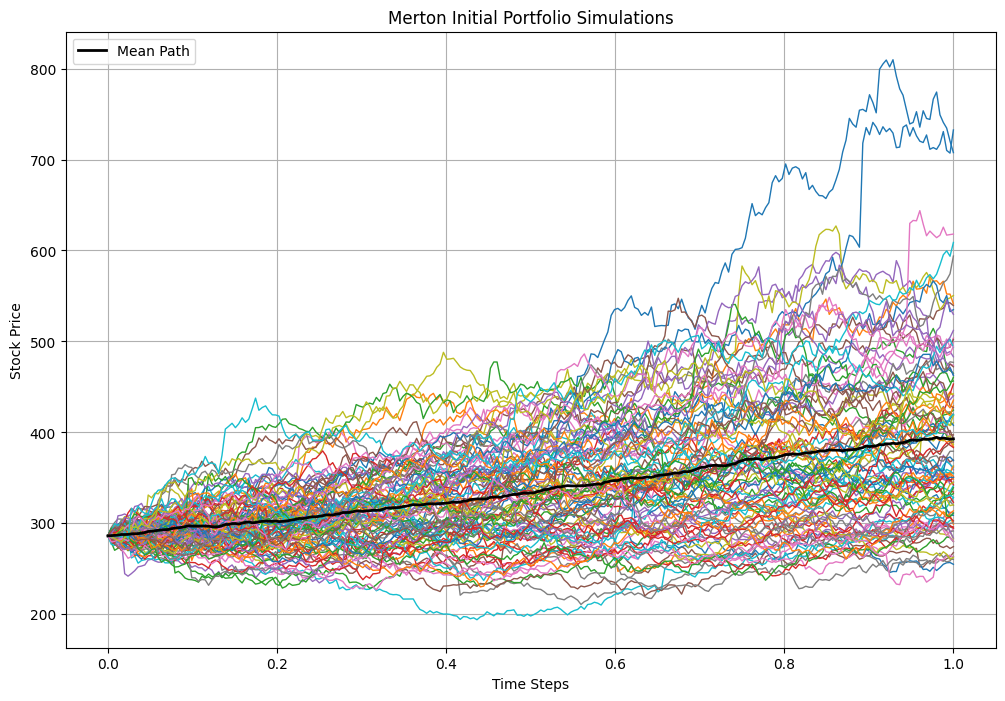

In [79]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [80]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 37.37%


### Constant Elasticity of Variance (CEV): 

Estimated XOM CEV Parameters: mu=0.0003140325278738727, std=0.008221730134211335, gamma=1.1070639574831078


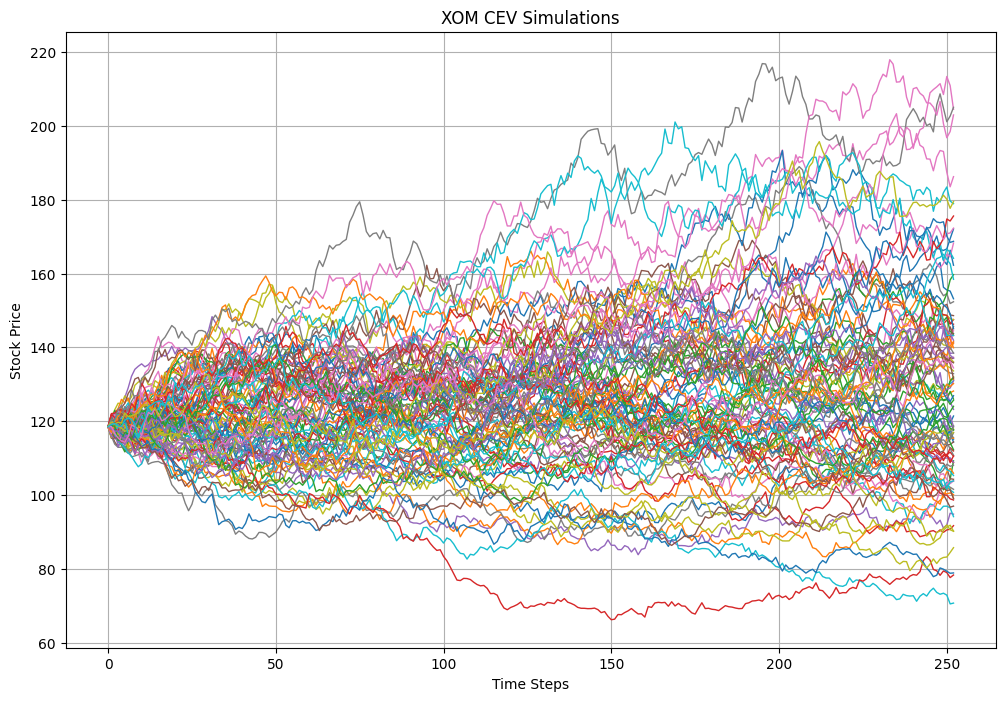

In [81]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated ATKR CEV Parameters: mu=0.0011576444163019725, std=0.06429998759115733, gamma=0.7942304171903691
Estimated BKNG CEV Parameters: mu=0.0012752617981977331, std=0.0005630776643139411, gamma=1.4214144917620677
Estimated BN CEV Parameters: mu=0.0004798457196535127, std=0.6453135650763512, gamma=0.0
Estimated FI CEV Parameters: mu=0.0008851478378471625, std=1.3013306383472245, gamma=0.00013760840503559407
Estimated GOOG CEV Parameters: mu=0.0017975469747859097, std=0.01088786524405591, gamma=1.0906852769467206
Estimated NKE CEV Parameters: mu=-0.0005178664232174165, std=0.00020533316173004695, gamma=1.952249638973657
Estimated SBUX CEV Parameters: mu=-6.979918921026005e-05, std=0.0001474600079740294, gamma=1.9917191568940564
Estimated STLD CEV Parameters: mu=0.0010212192074432389, std=2.0439460179844935, gamma=0.0
Estimated VICI CEV Parameters: mu=-0.0005683713044855697, std=0.35908156682187736, gamma=0.0
Estimated XOM CEV Parameters: mu=0.0003140325278738727, std=0.008221730134211

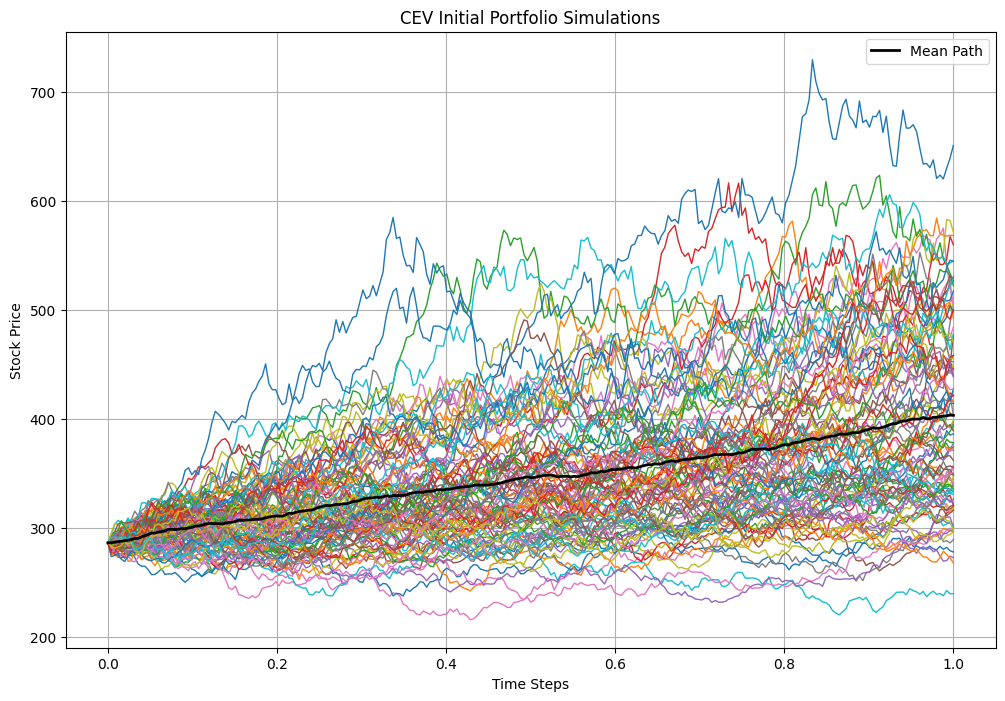

In [82]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [83]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

CEV Initial Portfolio Return: 40.84%


### Heston Model:

Calibrated XOM parameters: theta=0.09915247696595028, kappa=1.618294766923172, sigma=0.5943679723969357, rho=-0.9999832803415023, v0=0.01367065386008568


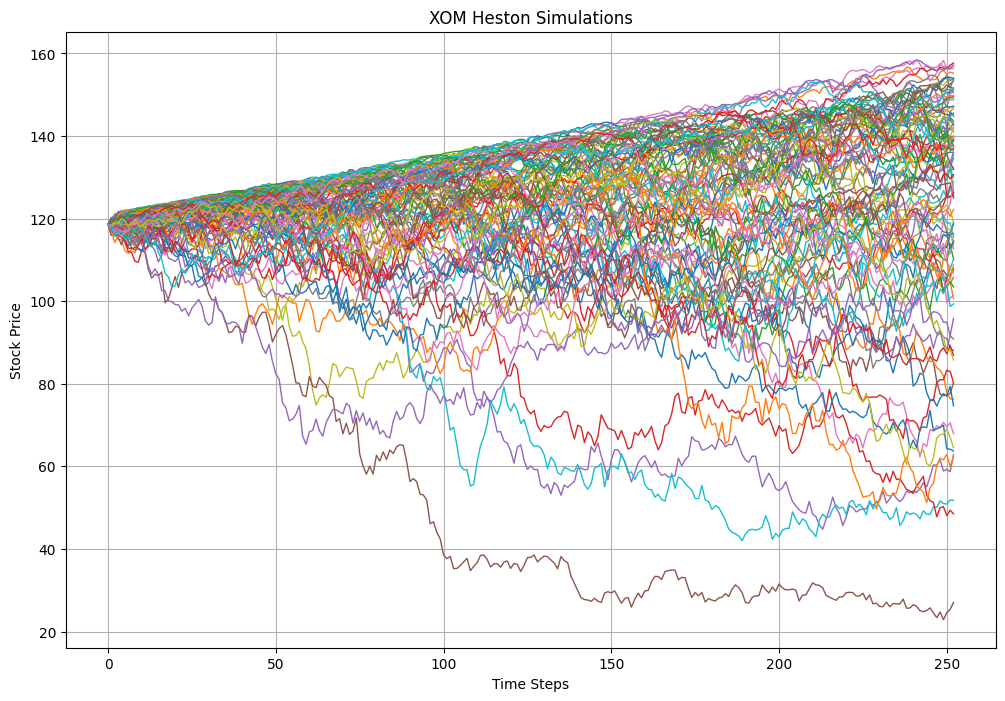

In [84]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')

Calibrated ATKR parameters: theta=0.04717430615603908, kappa=1.3061442193262398e-08, sigma=1.3065444696930408, rho=-0.9878158755708875, v0=0.06796340607206725
Calibrated BKNG parameters: theta=0.2308048366039269, kappa=14.413957441630934, sigma=0.6714053551010436, rho=0.9999290083351554, v0=0.09530307783448312
Calibrated BN parameters: theta=0.46350291444063824, kappa=10.349175462474813, sigma=0.7051426850512379, rho=0.9999062663746594, v0=0.1392219604295316
Calibrated FI parameters: theta=0.1108595625715294, kappa=2.0244926958119405, sigma=0.6988568847962281, rho=-0.9999706706305747, v0=0.010511423298393488
Calibrated GOOG parameters: theta=0.1885281008479809, kappa=0.9144627593777509, sigma=0.5849442309389427, rho=-0.9999793488195123, v0=0.013869350057536516
Calibrated NKE parameters: theta=1.5106310892992127, kappa=28.249196135074367, sigma=1.8161292759765828, rho=-0.6645954684129751, v0=1.6439753197223692e-07
Calibrated SBUX parameters: theta=0.2987025525193786, kappa=0.98155076542

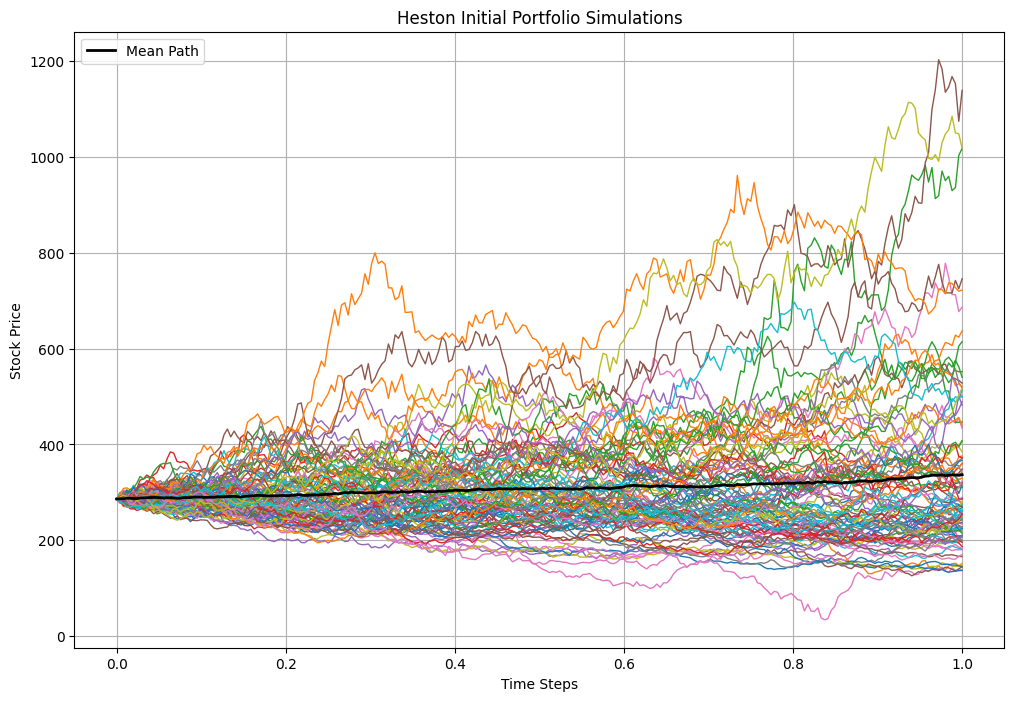

In [85]:
heston_init_port=dat_func.simulate_heston_portfolio(stock_df,init_weights,risk_free_rate)
vis.plot_paths(heston_init_port.iloc[:100],'Heston Initial Portfolio',True)

In [86]:
heston_ret=(heston_init_port.mean(axis=0).iloc[-1]-heston_init_port.mean(axis=0).iloc[0])/heston_init_port.mean(axis=0).iloc[0]
print(f'Heston Initial Portfolio Return: {round(heston_ret*100,2)}%')

Heston Initial Portfolio Return: 3.69%
